Implementation of `LorA: Low-Rank Adaptation of Large Language Models` paper in pytorch with a short touch-up on matrix theory.

In [181]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from transformers import ViTForImageClassification, ViTConfig

from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTImageProcessor 

from tqdm import tqdm

#### Matrix Rank 

Any matrix $A$ of rank k can be decomposed into a long and skinny matrix times a short and long one.


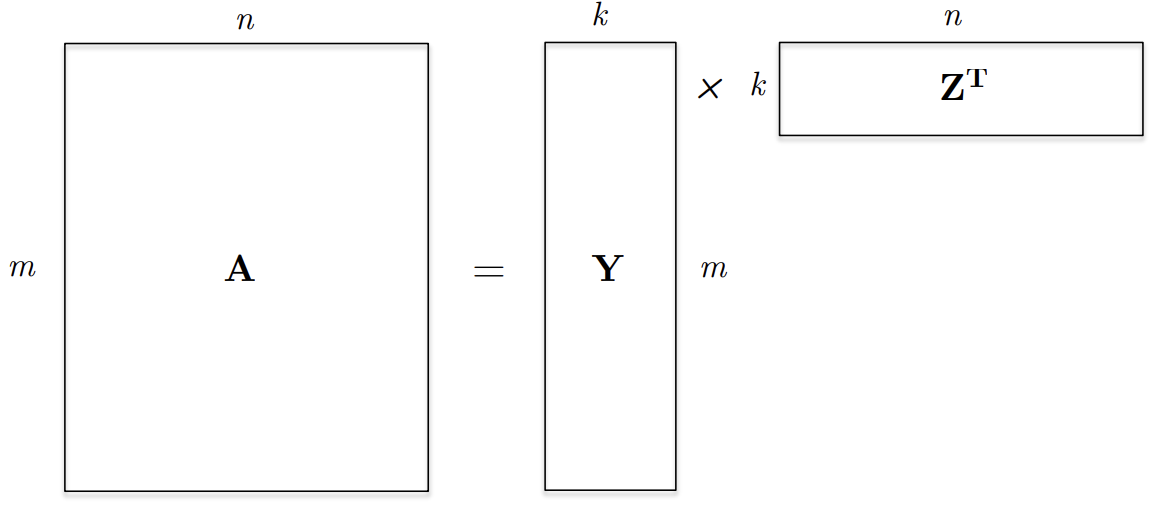

The general definition of matrix ank is as following: a matrix $A$ has rank $k$ if it can be written as te sum of two rank-1 matrices. In other words, $A$ can be written as the product of a long and skinny $(m \times k)$ matrix $Y$ and a short and long $(k \times n)$ matrix $Z^{T}$.

In the below example, Row 3 = Row 1 + Row 2 ⇒ not independent. Only Row 1 and Row 2 are independent ⇒ rank = 2.

In [183]:
A = torch.tensor([
    [1, 2, 3],
    [4, 5, 6],
    [5, 7, 9]   # This row = row1 + row2
], dtype=torch.float32)

torch.linalg.matrix_rank(A)

tensor(2)

All rows are linearly independent ⇒ rank = 3.

In [184]:
B = torch.tensor([
    [1, 2, 3],
    [4, 0, 6],
    [7, 8, 9]
], dtype=torch.float32)

torch.linalg.matrix_rank(B)

tensor(3)

Each row is a multiple of [1, 2] → same direction → rank = 1.

In [185]:
C = torch.tensor([
    [2, 4],
    [1, 2],
    [3, 6]
], dtype=torch.float32)

torch.linalg.matrix_rank(C)

tensor(1)

No information, just zeros ⇒ rank = 0.

In [186]:
Z = torch.zeros((4, 4))
torch.linalg.matrix_rank(Z)

tensor(0)

#### Matrix Decomposition

Matrix decomposition is the process of breaking a matrix into simpler matrices (often to expose structure or reduce computation). Such process approximates a given matrix $A$ with a rank-$k$ matrix, for a target rank $k$. Such a matrix is called a low-rank approximation. A low-rank approximation provides a (lossy) compressed version of the matrix. 

Methods (just the types):
1. Signular Value Decomposition (SVD)
2. Low-Rank Approximation from SVD 

#### LoRA Theory

As mentioned in the paper, "LoRA allows us to train some dense layers in a neural network indirctly by optimizing rank decomposition matrices of the dense layers' change during adapttion instead, while keeping the pre-trained weights frozen", as shown in the illustration below.

<div style="text-align: center;"><img src="./public/lora.png"></img></div>

LoRA possess several advantages, summarised from the paper:
* A pre-trained model can be shared and used to build many small LoRA modules for dif-
ferent tasks. We can freeze the shared model and efﬁciently switch tasks by replacing the
matrices A and B in the Figure above, reducing the storage requirement and task-switching over-
head signiﬁcantly.
* LoRA makes training more efﬁcient and lowers the hardware barrier to entry by up to 3
times when using adaptive optimizers since we do not need to calculate the gradients or
maintain the optimizer states for most parameters. Instead, we only optimize the injected,
much smaller low-rank matrices.
* The simple linear design allows us to merge the trainable matrices with the frozen weights
when deployed, introducing no inference latency compared to a fully ﬁne-tuned model, by
construction.

Therefore, LoRA freezes pre-trained model weights and injects trainable rank decomposition matrices into each layer of the transformer. This makes it possible to efficiently fine-tune large langauge models by reducing trainable parameters by a large factor.

LoRA linear layer adds a low-rank decomposition to the pre-trained weight matrix $W \in \Bbb R^{d \times k} $ of the linear layer. It proposes freezing the original weights and injecting low-rank update matrices into each layer

| Symbol      | Meaning | Description |
| ----- | ---------------------- | -------------------------------------------- |
| $W_{0}$      | Weight Matrix          | Initial pre-trained weight matrix $\in \Bbb R^{d \times k}$.      |
| $k$      | Input Dimension          | The number of features going into the layer.      |
| $d$      | Output  Dimension        | The number of features coming out of the layer.  |
| $r$      | LoRA rank (compression dim) | The intrinsic dimension used to approximate the weight update. It controls the size of the low-rank update matrix $\Delta W = BA$.  |
| $A$      | Down projection        | $r \times k$  |
| $B$      | Up projection        | $d \times r$ |
| $x$      | Input vector        | The vector $\in \Bbb R^{k}$, however, it is passed to the layer as batch of shape $(n, k)$ |
| $BAx$      | Low-rank update        | $\in \Bbb R^{d}$ |


If a layer's weight is $W_{0} \in \Bbb R^{d \times k} $, LoRA represents the weight update as $W_{0} + \Delta W = W_{0} + BA $, where:
* $B  \in  \Bbb R^{d \times r}$
* $A  \in  \Bbb R^{r \times k}$
* Both $B$ and $A$ have much smaller inner dimension $r << min(d, k)$.

During training, $W_{0}$ stays frozen, and only A,B are learned. The forward pass througgh this adapted layer is them $h = W_{0}x + (BA)x$, often scaled by a factor $\frac{\alpha}{r}$. for stability. This effectively adds a small "change" matrix BA to the base layer's output without modifying $W_{0}$.

Standard `Linear` dense layers with $W_{0} \in \Bbb R^{d \times k} $ and input $x \in \Bbb R^{k} $ computes $W_{0}x + bias$. LoRA views this weight matrix as full-rank (rank $min(𝑑,𝑘)$) in general. And instead of fine-tunning $W_{0}$, it adds two smaller matrices, $B$ and $A$ whose product $BA$ is rank-$r$. Both $B$ and $A$ are multiplied by the same input $x$ (first $Ax \in \Bbb R^{r}$, then $B(Ax) \in \Bbb R^{d}$) and summed with $W_{0}x$.

By choosing $r$ small (even 1-4 for large layers), the number of trainable parameters drops dramatically, yet $W_{0} + BA$ still has a dimension $d x k$ and affects the layer's output.

#### LoRA Linear Layer Implementation

In [131]:
class LoRALinear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool, r: int, alpha: int = None):
        super().__init__()

        # Notes:
        # x shape         : (batch_size, k)
        # A.T shape       : (k, r)
        # x @ A.T         : (batch_size, r)     == Ax
        # B.T shape       : (r, d_out)
        # (Ax) @ B.T      : (batch_size, d_out) == B(Ax)

        
        # Set α=r is not provided 
        # i.e. make the scaling factor alpha/r =1 as initially set alpha to the first r and we do not tune it.
        if alpha is None:
            alpha = r

        # Initial Weight Frozen
        self.weight = nn.Parameter(torch.empty(size=(out_features, in_features))) # W0
        self.weight.requires_grad = False

        if bias:
            self.bias = nn.Parameter(torch.empty(out_features)) # or torch.empty((out_features,))
            self.bias.requires_grad = False
        else:
            self.bias = None

        # scaling delta W by alpha/r as in the paper
        self.scaling = alpha / r

        self.lora_a = nn.Parameter(torch.empty(size=(r, in_features)))
        self.lora_b = nn.Parameter(torch.empty(size=(out_features, r)))

        # From the paper: 
        # "We use a random Gaussian initialization for A and zero for B, so ∆W = BA is zero at the beginning of training"
        with torch.no_grad():
            nn.init.kaiming_uniform_(self.lora_a, a=5 ** 0.5)
            nn.init.zeros_(self.lora_b)

    def forward(self, x: torch.Tensor):
        output = nn.functional.linear(x, self.weight, bias=self.bias) # W0
        output += (x @ self.lora_a.T @ self.lora_b.T) * self.scaling

        return output

In [132]:
layer = LoRALinear(
    in_features = 10, # k
    out_features = 10, # d
    bias = True, 
    r = 4,
    alpha = None
)

x = torch.ones((8, 10)) # n, k
y = layer(x)

In [134]:
print(y.shape)
assert x.shape == y.shape, "Shapes not matching"

torch.Size([8, 10])


Only `lora_a` and `lora_b` must be trainable.

In [135]:
list(layer.named_parameters())

[('weight',
  Parameter containing:
  tensor([[-4.3908e+06,  4.5783e-41, -6.5029e+22,  3.0910e-41, -2.0746e+06,
            4.5783e-41, -2.2348e-16,  4.5782e-41, -2.2348e-16,  4.5782e-41],
          [-2.2348e-16,  4.5782e-41, -1.9009e+06,  4.5783e-41, -2.2348e-16,
            4.5782e-41,  1.1339e+22,  4.5782e-41, -1.7726e+06,  4.5783e-41],
          [-1.9427e+06,  4.5783e-41, -1.7726e+06,  4.5783e-41,  1.1339e+22,
            4.5782e-41, -4.0910e-22,  4.5783e-41, -1.9427e+06,  4.5783e-41],
          [ 1.1339e+22,  4.5782e-41, -4.0910e-22,  4.5783e-41, -1.9427e+06,
            4.5783e-41,  1.1339e+22,  4.5782e-41, -2.1381e+06,  4.5783e-41],
          [-1.9426e+06,  4.5783e-41, -1.7726e+06,  4.5783e-41, -2.1381e+06,
            4.5783e-41, -2.1381e+06,  4.5783e-41,  1.1339e+22,  4.5782e-41],
          [-2.2348e-16,  4.5782e-41, -1.9427e+06,  4.5783e-41, -6.4976e+04,
            4.5783e-41, -1.9009e+06,  4.5783e-41, -1.9428e+06,  4.5783e-41],
          [-1.9009e+06,  4.5783e-41, -1.9009e+

#### Testing LoRA implementation on a HuggingFace vision model and CIFAR-10 dataset

In [144]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=10)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [145]:
print("Model before LoRA")
model

Model before LoRA


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [146]:
def inject_lora_in_vit(model, r=8):
    for block in model.vit.encoder.layer:
        # grab original dense layers
        d = block.attention.attention.query.in_features
        # replace with LoRA versions for query and value
        block.attention.attention.query = LoRALinear(d, d, bias=False, r=r)
        block.attention.attention.value = LoRALinear(d, d, bias=False, r=r)

inject_lora_in_vit(model, r=4)

Injecting the LoRA can be seen in the model where the linear layers changed to the `LoRALinear`.

In [147]:
print("Model after LoRA")
model

Model after LoRA


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): LoRALinear()
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): LoRALinear()
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): ViTOutput(
      

In [152]:
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k") # ViTFeatureExtractor will be depricated
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(feature_extractor.image_mean, feature_extractor.image_std)
])

train_ds = CIFAR10(root='data', train=True, download=True, transform=transform)
test_ds  = CIFAR10(root='data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=16)

In [163]:
print(str(len(train_loader)) + " x 16 samples.\n" + str(len(test_loader))+ " x 16 samples.")

3125 x 16 samples.
625 x 16 samples.


In [168]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    for xb, yb in tqdm(loader):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=xb).logits
        loss = F.cross_entropy(outputs, yb)
        loss.backward()
        optimizer.step()

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(pixel_values=xb).logits
            preds = logits.argmax(dim=-1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total

Run both training cells below when large GPU is available.

In [173]:
# model_full = ViTForImageClassification.from_pretrained(
#     "google/vit-base-patch16-224-in21k", num_labels=10
# ).to(device)
# opt_full = optim.Adam(model_full.parameters(), lr=3e-5)

# train_one_epoch(model_full, train_loader, opt_full, device)
# acc_full = evaluate(model_full, test_loader, device)

In [180]:
# model_lora = ViTForImageClassification.from_pretrained(
#     "google/vit-base-patch16-224-in21k", num_labels=10
# )
# inject_lora_in_vit(model_lora, r=4)

# # Freeze everything except LoRA
# for name, param in model_lora.named_parameters():
#     if "lora_" not in name:
#         param.requires_grad = False

# model_lora = model_lora.to(device)
# opt_lora = optim.Adam(filter(lambda p: p.requires_grad, model_lora.parameters()), lr=3e-5)

# train_one_epoch(model_lora, train_loader, opt_lora, device)
# acc_lora = evaluate(model_lora, test_loader, device)